In [71]:
import re
import pandas as pd
import numpy as np

## Plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Pytorch Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

## NLP Libraries
import spacy
from sklearn.model_selection import train_test_split
from nltk import download
import gensim
from nltk.corpus import stopwords
spacy_en = spacy.load('en')
download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Reading Dataset

In [5]:
train = pd.read_csv('train.csv')
print(len(train))
train.tail()

19579


,id,text,author
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP
19578,id00393,"He laid a gnarled claw on my shoulder, and it ...",HPL


In [6]:
test = pd.read_csv('test.csv')
print(len(test))
test.tail()

8392


,id,text
8387,id11749,All this is now the fitter for my purpose.
8388,id10526,I fixed myself on a wide solitude.
8389,id13477,It is easily understood that what might improv...
8390,id13761,"Be this as it may, I now began to feel the ins..."
8391,id04282,"Long winded, statistical, and drearily genealo..."


In [7]:
## Checking dataset unbalance

In [18]:
EAP = train[train['author']=='EAP']
EAP_size = len(EAP)
print(EAP_size)
EAP.tail()

7900


,id,text,author
19572,id03325,But these and other difficulties attending res...,EAP
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


In [17]:
HPL = train[train['author']=='HPL']
HPL_size = len(HPL)
print(HPL_size)
HPL.tail()

5635


,id,text,author
19554,id07976,"They admitted they had been drunk, but both vo...",HPL
19559,id18823,When a fumbling came in the nearer casements h...,HPL
19561,id08678,Average people in society and business New Eng...,HPL
19571,id14420,"My watch was still going, and told me that the...",HPL
19578,id00393,"He laid a gnarled claw on my shoulder, and it ...",HPL


In [16]:
MWS = train[train['author']=='MWS']
MWS_size = len(MWS)
print(MWS_size)
MWS.tail()

6044


,id,text,author
19563,id10563,Yet from whom has not that rude hand rent away...,MWS
19566,id00832,"These reflections made our legislators pause, ...",MWS
19569,id26790,Once my fancy was soothed with dreams of virtu...,MWS
19570,id14263,"Nay, you may have met with another whom you ma...",MWS
19573,id07567,Stress of weather drove us up the Adriatic Gul...,MWS


In [15]:
sns.set(style="white", context="talk")

In [23]:
x=np.array([EAP_size,MWS_size,HPL_size])
y=np.arange(1,4)
x,y

(array([7900, 6044, 5635]), array([1, 2, 3]))

In [ ]:
ax1

[]

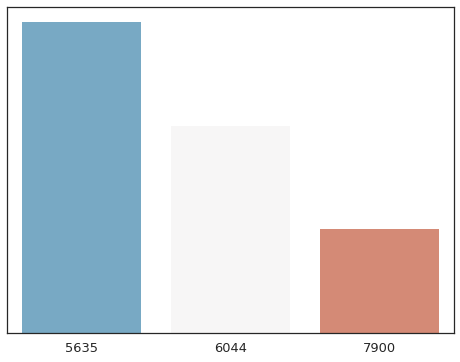

In [33]:
f, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(x, y, palette="RdBu_r", ax=ax1)
plt.setp(f.axes,yticks=[])

## 3. Preprocessing

In [34]:
def transformText(text, do_stop=False, do_stem=False):
    
    stops = set(stopwords.words("english"))
    
    # Convert text to lower
    text = text.lower()
    
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Removing all the stopwords
    
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]

    # Removing all the tokens with lesser than 3 characters
    filtered_words = gensim.corpora.textcorpus.remove_short(filtered_words, minsize=2)
    
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    if (do_stem==True):
        # Stemming
        text = gensim.parsing.preprocessing.stem_text(text)
    return text

In [35]:
train['phrase_preprocessed']=train['text'].apply(lambda x: transformText(x,do_stop=False, do_stem=False))
train.head()

,id,text,author,phrase_preprocessed
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was gold snuff box from which...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...


In [41]:
test['phrase_preprocessed']=test['text'].apply(lambda x: transformText(x,do_stop=False, do_stem=False))
test.head()

,id,text,phrase_preprocessed
0,id02310,"Still, as I urged our leaving Ireland with suc...",still as urged our leaving ireland with such i...
1,id24541,"If a fire wanted fanning, it could readily be ...",if fire wanted fanning it could readily be fan...
2,id00134,And when they had broken down the frail door t...,and when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...,while was thinking how should possibly manage ...
4,id04081,I am not sure to what limit his knowledge may ...,am not sure to what limit his knowledge may ex...


## 4. Train/Test split, Vocab

In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(train['phrase_preprocessed'],
                                                      train['author'], 
                                                      test_size=0.2)

In [43]:
x_test = np.array(test['phrase_preprocessed'])
x_test

array([ 'still as urged our leaving ireland with such inquietude and impatience my father thought it best to yield ',
       'if fire wanted fanning it could readily be fanned with newspaper and as the government grew weaker have no doubt that leather and iron acquired durability in proportion for in very short time there was not pair of bellows in all rotterdam that ever stood in need of stitch or required the assistance of hammer ',
       'and when they had broken down the frail door they found only this two cleanly picked human skeletons on the earthen floor and number of singular beetles crawling in the shadowy corners ',
       ...,
       'it is easily understood that what might improve closely scrutinized detail may at the same time injure general or more distantly observed effect ',
       'be this as it may now began to feel the inspiration of burning hope and at length nurtured in my secret thoughts stern and desperate resolution that would submit no longer to be enslaved ',

In [44]:
## Build Vocabulary
word_to_ix = {}
for sent in list(x_train) + list(x_valid) + list(x_test):
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In [50]:
print("Vocabulary size: {}".format(len(word_to_ix)))

Vocabulary size: 28307


In [51]:
label_to_ix = { "EAP": 0, "MWS": 1, "HPL": 2 }

In [52]:
VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = len(label_to_ix)
VOCAB_SIZE, NUM_LABELS

(28307, 3)

## 5. Making dataset iterable

In [53]:
train_data=list(zip(x_train,y_train))
train_data[0:5]

[('about midway in the short vista which my dreamy vision took in one small circular island profusely verdured reposed upon the bosom of the stream ',
  'EAP'),
 (' o aira city of marble and beryl how many are thy beauties how loved the warm and fragrant groves across the hyaline nithra and the falls of the tiny kra that flowed through the verdant valley in those groves and in that vale the children wove wreaths for one another and at dusk dreamed strange dreams under the yath trees on the mountain as saw below me the lights of the city and the curving nithra reflecting ribbon of stars ',
  'HPL'),
 ('instances of desertion became more frequent and even murders which made the hearer sick with horror where the fear of contagion had armed those nearest in blood against each other ',
  'MWS'),
 ('generation after generation lived and felt and died there and in days when people weren t afraid to live and feel and die ',
  'HPL'),
 ('would you also create for yourself and the world demoniac

In [54]:
valid_data=list(zip(x_valid,y_valid))
valid_data[0:5]

[('the first horrible incident of our acquaintance was the greatest shock ever experienced and it is only with reluctance that repeat it ',
  'HPL'),
 ('mr the student swooned ', 'EAP'),
 ('could only think of the bourne of my travels and the work which was to occupy me whilst they endured ',
  'MWS'),
 ('packed up my chemical instruments and the materials had collected resolving to finish my labours in some obscure nook in the northern highlands of scotland ',
  'MWS'),
 ('the fits grow successively more and more distinctive and endure each for longer term than the preceding ',
  'EAP')]

In [78]:
def make_context_vector(seq, to_ix):
    idxs = [to_ix[w] for w in seq.split()]
    tensor = torch.LongTensor(idxs)
    return tensor

In [79]:
def make_target(label, label_to_idx):
    return torch.LongTensor([label_to_idx[label]])

## 6. Model - LSTM Classifier with Word2vec

In [59]:
!ls ../../vectors/

glove.42B.300d.txt   GoogleNews-vectors-negative300.bin
glove.840B.300d.txt  wiki.en.zip


In [60]:
from gensim.models import KeyedVectors

In [61]:
w2v = KeyedVectors.load_word2vec_format('../../vectors/GoogleNews-vectors-negative300.bin', binary = True)

In [62]:
W2V_DIM = 300
## standard deviation to use
sd = 1/np.sqrt(W2V_DIM)
## Random initialization
weights = np.random.normal(0, scale=sd, size=[VOCAB_SIZE, W2V_DIM])
weights = weights.astype(np.float32)

In [63]:
for word in word_to_ix:
    id = word_to_ix.get(word,None)
    if id is not None:
        try:
            weights[id]=w2v.wv.word_vec(word)
        except:
            weights[id]=np.random.normal(0, scale=sd, size=[1, W2V_DIM]) ## If word not present, initialize randomly

In [64]:
word_to_ix

{'about': 0,
 'midway': 1,
 'in': 2,
 'the': 3,
 'short': 4,
 'vista': 5,
 'which': 6,
 'my': 7,
 'dreamy': 8,
 'vision': 9,
 'took': 10,
 'one': 11,
 'small': 12,
 'circular': 13,
 'island': 14,
 'profusely': 15,
 'verdured': 16,
 'reposed': 17,
 'upon': 18,
 'bosom': 19,
 'of': 20,
 'stream': 21,
 'o': 22,
 'aira': 23,
 'city': 24,
 'marble': 25,
 'and': 26,
 'beryl': 27,
 'how': 28,
 'many': 29,
 'are': 30,
 'thy': 31,
 'beauties': 32,
 'loved': 33,
 'warm': 34,
 'fragrant': 35,
 'groves': 36,
 'across': 37,
 'hyaline': 38,
 'nithra': 39,
 'falls': 40,
 'tiny': 41,
 'kra': 42,
 'that': 43,
 'flowed': 44,
 'through': 45,
 'verdant': 46,
 'valley': 47,
 'those': 48,
 'vale': 49,
 'children': 50,
 'wove': 51,
 'wreaths': 52,
 'for': 53,
 'another': 54,
 'at': 55,
 'dusk': 56,
 'dreamed': 57,
 'strange': 58,
 'dreams': 59,
 'under': 60,
 'yath': 61,
 'trees': 62,
 'on': 63,
 'mountain': 64,
 'as': 65,
 'saw': 66,
 'below': 67,
 'me': 68,
 'lights': 69,
 'curving': 70,
 'reflecting': 71,

In [65]:
w2v.wv.word_vec("star")[0:50]

array([ 0.1640625 ,  0.18847656,  0.14160156, -0.02941895,  0.02087402,
        0.13769531, -0.0168457 , -0.32617188,  0.07519531, -0.05200195,
        0.11816406,  0.09179688,  0.06689453, -0.04614258, -0.04321289,
        0.38476562,  0.0213623 , -0.09423828,  0.05712891,  0.18066406,
       -0.08740234,  0.3359375 , -0.078125  , -0.07861328, -0.02111816,
       -0.28320312,  0.08740234,  0.1796875 ,  0.11083984,  0.0480957 ,
       -0.00469971,  0.03857422,  0.01940918,  0.15332031,  0.07714844,
        0.01574707,  0.21875   ,  0.16113281, -0.14257812,  0.12695312,
        0.04736328, -0.48242188,  0.10302734,  0.11816406,  0.24316406,
       -0.00631714, -0.04858398,  0.05395508,  0.31835938,  0.16113281], dtype=float32)

In [66]:
word_to_ix['star']

791

In [68]:
weights[791][0:50]

array([ 0.1640625 ,  0.18847656,  0.14160156, -0.02941895,  0.02087402,
        0.13769531, -0.0168457 , -0.32617188,  0.07519531, -0.05200195,
        0.11816406,  0.09179688,  0.06689453, -0.04614258, -0.04321289,
        0.38476562,  0.0213623 , -0.09423828,  0.05712891,  0.18066406,
       -0.08740234,  0.3359375 , -0.078125  , -0.07861328, -0.02111816,
       -0.28320312,  0.08740234,  0.1796875 ,  0.11083984,  0.0480957 ,
       -0.00469971,  0.03857422,  0.01940918,  0.15332031,  0.07714844,
        0.01574707,  0.21875   ,  0.16113281, -0.14257812,  0.12695312,
        0.04736328, -0.48242188,  0.10302734,  0.11816406,  0.24316406,
       -0.00631714, -0.04858398,  0.05395508,  0.31835938,  0.16113281], dtype=float32)

In [69]:
W2V_DIM = 300
HIDDEN_DIM = 60
NUM_LAYERS = 2
DROPOUT = 0.5

In [73]:
class GruClassifierW2vec(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, num_layers, vocab_size, label_size, pre_trained_weights, dropout):
        super(GruClassifierW2vec, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data=torch.Tensor(pre_trained_weights)
        self.gru = nn.GRU(input_size = embedding_dim,
                            hidden_size = hidden_dim,
                            num_layers = num_layers,
                            dropout = dropout)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden h
        return (Variable(torch.zeros(self.num_layers, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        x = embeds.view(len(sentence), 1, -1)
        for i in range(self.num_layers):
            gru_out, self.hidden = self.gru(x, self.hidden)
        y  = self.hidden2label(gru_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

In [74]:
model = GruClassifierW2vec(embedding_dim=W2V_DIM,
                            hidden_dim=HIDDEN_DIM,
                            num_layers=NUM_LAYERS,
                            vocab_size=VOCAB_SIZE,
                            label_size=NUM_LABELS,
                            pre_trained_weights = weights,
                            dropout = DROPOUT)

In [75]:
model

GruClassifierW2vec(
  (word_embeddings): Embedding(28307, 300)
  (gru): GRU(300, 60, num_layers=2, dropout=0.5)
  (hidden2label): Linear(in_features=60, out_features=3)
)

In [ ]:
## Loss function with mask to compensate class inbalance
# mask=torch.FloatTensor((1,1.37))
# loss_function = nn.CrossEntropyLoss(weight=mask)

In [76]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [77]:
sample=train_data[2][0]
sample

'instances of desertion became more frequent and even murders which made the hearer sick with horror where the fear of contagion had armed those nearest in blood against each other '

In [80]:
sample_context=Variable(make_context_vector(sample,word_to_ix))
sample_context

Variable containing:
 74
 20
 75
 76
 77
 78
 26
 79
 80
  6
 81
  3
 82
 83
 84
 85
 86
  3
 87
 20
 88
 89
 90
 48
 91
  2
 92
 93
 94
 95
[torch.LongTensor of size 30]

In [81]:
out=model(sample_context)
out

/home/ubuntu/Envs/nlp36/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Variable containing:
-1.0413 -1.0175 -1.2536
[torch.FloatTensor of size 1x3]

In [83]:
batch_size = 20
n_iters = 1500
num_epochs = n_iters/(len(x_train) / batch_size)
num_epochs = int(num_epochs)
num_epochs

1

In [ ]:
iter = 0
for epoch in range(num_epochs):
    for (sent,label) in train_data:
        # Step 1 - clear the gradients
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
    
        ## Avoid breaking for empty input
        try:
            ## Step 2- Prepare input and label
            context_vec = Variable(make_context_vector(sent, word_to_ix))
            target = Variable(make_target(label, label_to_ix)) 
            # Step 3 - Run forward pass
            output = model(context_vec)  
            # Step 4 - Compute loss, gradients, update parameters
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
        except:
            pass
        iter+=1      
        ## Calculate final accuracy
        if iter % 500 ==0:
            correct = 0
            total = 0
            for (sent,label) in valid_data:
                context_vec = Variable(make_context_vector(sent, word_to_ix))
                target = Variable(make_target(label, label_to_ix))
                output = model(context_vec)
                _,predicted = torch.max(output.data,1)
                total += target.size(0)
                correct += (predicted == make_target(label, label_to_ix)).sum()
            accuracy = 100 * correct/total
            print('Iterations: {}. Loss: {}'.format(iter,loss.data[0]))

/home/ubuntu/Envs/nlp36/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iterations: 500. Loss: 1.0241338014602661
Iterations: 1000. Loss: 0.6654553413391113
Iterations: 1500. Loss: 0.6815277338027954
Iterations: 2000. Loss: 0.45777907967567444
Iterations: 2500. Loss: 0.7934134006500244


In [ ]:
## Making predictions on Test set

In [ ]:
n=2
bow_vec = Variable(make_context_vector(valid_data[n][0], word_to_ix))
print("-"*20 + " INPUT "+"-"*30)
print("TRUE LABEL = {}".format(valid_data[n][1]))
print("SENTENCE = {}".format(valid_data[n][0]))
print("-"*20 + " PREDICTION "+"-"*30)
log_probs = model(bow_vec)
_,predicted = torch.max(log_probs.data,1)
print("PRED = {}".format(predicted[0]))
print("PRED = {}".format(list(label_to_ix.keys())[list(label_to_ix.values()).index(predicted[0])]))
##print("LOG_PROB = {}".format(log_probs))
print("PROBS = {}".format(F.softmax(log_probs)))

In [ ]:
## Generating submissions

In [ ]:
my_sub = pd.DataFrame(columns={'id', 'EAP','HPL', 'MWS'})
my_sub=my_sub[['id', 'EAP','HPL', 'MWS']]
my_sub

In [ ]:
for i in range(len(test)):
    my_sub.loc[i] = [test['id'][i], preds_proba[i][0], preds_proba[i][1], preds_proba[i][2]]

In [ ]:
my_sub.to_csv('roberto_new_2.csv',index=False)